# Linear nutrition

In [1]:
import os # need to happen before loading numpy
os.environ["OMP_NUM_THREADS"] = "8" # export OMP_NUM_THREADS=8
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=8
os.environ["MKL_NUM_THREADS"] = "8" # export MKL_NUM_THREADS=8
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=8
os.environ["NUMEXPR_NUM_THREADS"] = "8" # export NUMEXPR_NUM_THREADS=8

In [2]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f, create_linear_f
from on_manifold import OnManifoldExplainer, IndExplainer

if '../shap' not in sys.path:
    sys.path = ['../shap'] + sys.path
    import shap
    
import tqdm
from numba import jit
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as pl
from graphviz import Digraph
from collections import defaultdict
from sklearn.linear_model import LogisticRegression, LinearRegression

In [3]:
import dill
# dill.dump(cf_on_manifold_nutrition, open('NHANES1_cf_ind_linear.pkl', 'wb'))
# dill.dump(cf_flow_nutrition, open('NHANES1_cf_flow_linear.pkl', 'wb'))
# dill.dump(cf_ind_nutrition, open('NHANES1_cf_manifold_linear.pkl', 'wb'))

# cf_flow_nutrition = dill.load(open('NHANES1_cf_flow_linear.pkl', 'rb'))
# cf_on_manifold_nutrition = dill.load(open('NHANES1_cf_manifold_linear.pkl', 'rb'))
# cf_ind_nutrition = dill.load(open('NHANES1_cf_ind_linear.pkl', 'rb'))

In [4]:
X,y = shap.datasets.nhanesi()

X = X.fillna(X.mean())
y = np.abs(y) # ignore censoring, just do linear regression

X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values
# remove the first column: unnamed: 0
X = X.iloc[:, 1:]
X_display = X_display.iloc[:, 1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)

In [5]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)
f = model.predict

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_linear_f(feature_names, f)) # the target uses log(HR) instead of HR
A = ['Diastolic BP', 'Systolic BP']
D = ['Pulse pressure'] # Systolic BP - Diastolic BP
causal_links.add_causes_effects(A, D, lambda dbp, sdp: sdp-dbp)
A = ['Age', 'Sex', 'Poverty index', 'Race']
D = list(set(feature_names) - set(A) - set(['Pulse pressure']))
causal_links.add_causes_effects(A, D)
A = ['Age', 'Sex', 'Race']
D = ['Poverty index']
causal_links.add_causes_effects(A, D)

causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name, method='linear')

learning dependency for Serum Albumin: 100%|██████████| 14/14 [00:00<00:00, 107.58it/s]    


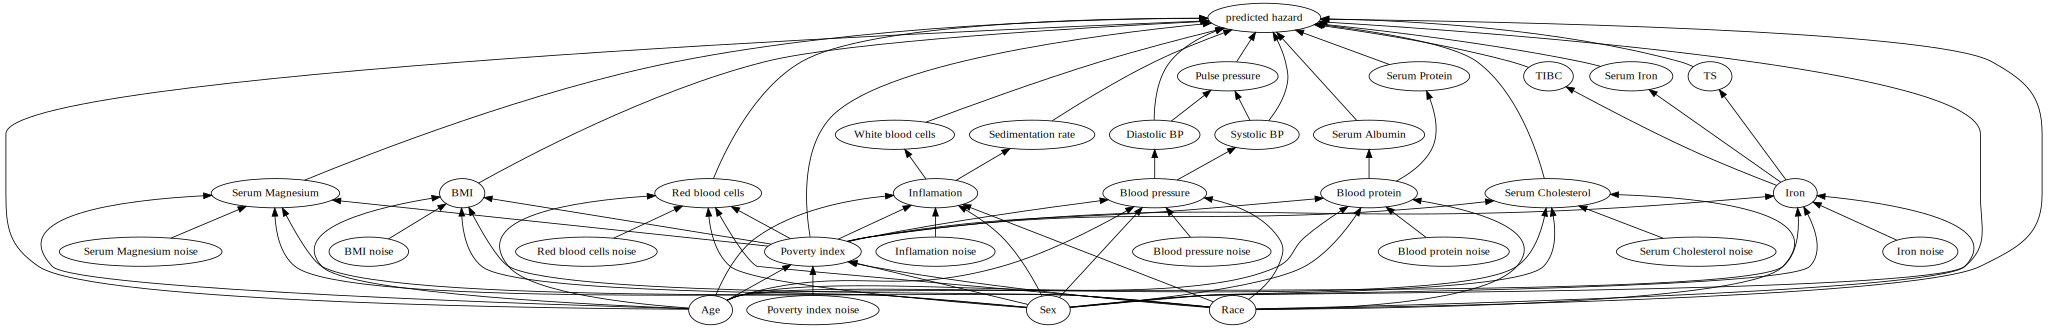

In [6]:
# for multiple baseline need to run this multiple times, finally I can just combine the different baselines because of linearity
E = GraphExplainer(causal_graph, X)
E.prepare_graph(X) # add noise node
G = copy.deepcopy(E.graph)
G = group_nodes(G, [n for n in G if n.name in ['White blood cells', 'Sedimentation rate']], 'Inflamation')
G = group_nodes(G, [n for n in G if n.name in ['Systolic BP', 'Diastolic BP']], 'Blood pressure')
G = group_nodes(G, [n for n in G if n.name in ['TS', 'TIBC', 'Serum Iron']], 'Iron')
G = group_nodes(G, [n for n in G if n.name in ['Serum Protein', 'Serum Albumin']], 'Blood protein')
G.draw()

In [12]:
from collections import defaultdict
n_bg = 10
bg = X.fillna(X.mean()).sample(n_bg)

# need to do this because graph explainer copies new nodes
def convert2node_dict(name_edge_credit, graph):
    name2node = {node.name: node for node in graph}
    res = defaultdict(lambda: defaultdict(int))
    for node1, d in name_edge_credit.items():
        for node2, val in d.items():
            res[name2node[node1]][name2node[node2]] = val
    return res

def multiple_baseline(bg, graph, X, nruns=10, n_explain=100, skip_prepare=False):
    # multiple baseline result
    edge_credit = defaultdict(lambda: defaultdict(int))
    for i in range(len(bg)):
        cf = GraphExplainer(graph, X, nruns=nruns, bg=bg[i:i+1]).shap_values(X[:n_explain], skip_prepare=skip_prepare)
        # explainer = GraphExplainer(graph, X, nruns=nruns, bg=bg[i:i+1]) 
        # cf = explainer.shap_values(X[:nsamples], skip_prepare=True)

        for node1, d in cf.edge_credit.items():
            for node2, val in d.items():
                a = edge_credit[node1.name][node2.name]
                b = cf.edge_credit[node1][node2]
                edge_credit[node1.name][node2.name] = (a * i + b) / (i + 1)
        
    # need to do this because graph explainer copies new nodes
    edge_credit = convert2node_dict(edge_credit, cf.graph)
    cf.edge_credit = edge_credit
    return cf

In [13]:
n_explain = 100
cf_flow_nutrition = multiple_baseline(bg, G, X, nruns=1, n_explain=n_explain, skip_prepare=True)

# n_explain = 100
# cf_flow_nutrition = GraphExplainer(G, X, nruns=1).shap_values(X[:n_explain], skip_prepare=True)

bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


In [20]:
# multiple baseline
explainer = OnManifoldExplainer(f, bg, nruns=10, sigma_sq=0.1, single_bg=False)
cf_on_manifold_nutrition = explainer.shap_values(X.fillna(X.mean())[:n_explain])

# single baseline
# explainer = OnManifoldExplainer(f, X, nruns=10, sigma_sq=0.1)
# cf_on_manifold_nutrition = explainer.shap_values(X[:n_explain])

  0%|          | 0/100 [00:00<?, ?it/s]invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value enco

KeyboardInterrupt: 

In [21]:
n_explain = 100
cf_ind_nutrition = multiple_baseline(bg, flatten_graph(G), X, nruns=1, n_explain=n_explain, skip_prepare=True)

# single baseline
# explainer = IndExplainer(f, X, nruns=10)
# cf_ind_nutrition = explainer.shap_values(X[:n_explain])

bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


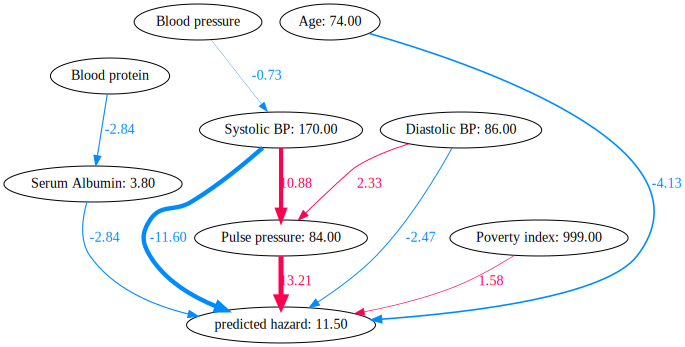

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f3baf032120>>

In [22]:
sample_ind = 2
cf_flow_nutrition.draw(sample_ind, max_display=10)

In [23]:
cf_on_manifold_nutrition.draw(sample_ind)

NameError: name 'cf_on_manifold_nutrition' is not defined

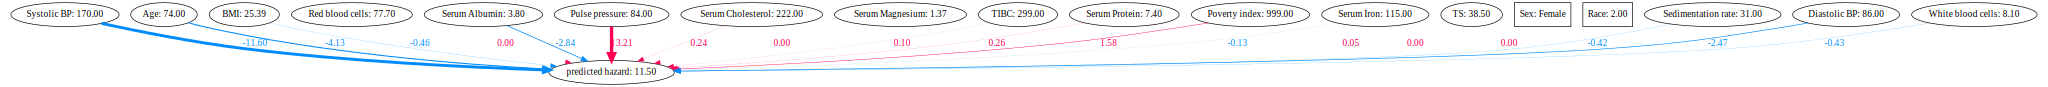

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f3bae0aec00>>

In [24]:
cf_ind_nutrition.draw(sample_ind)

ASV


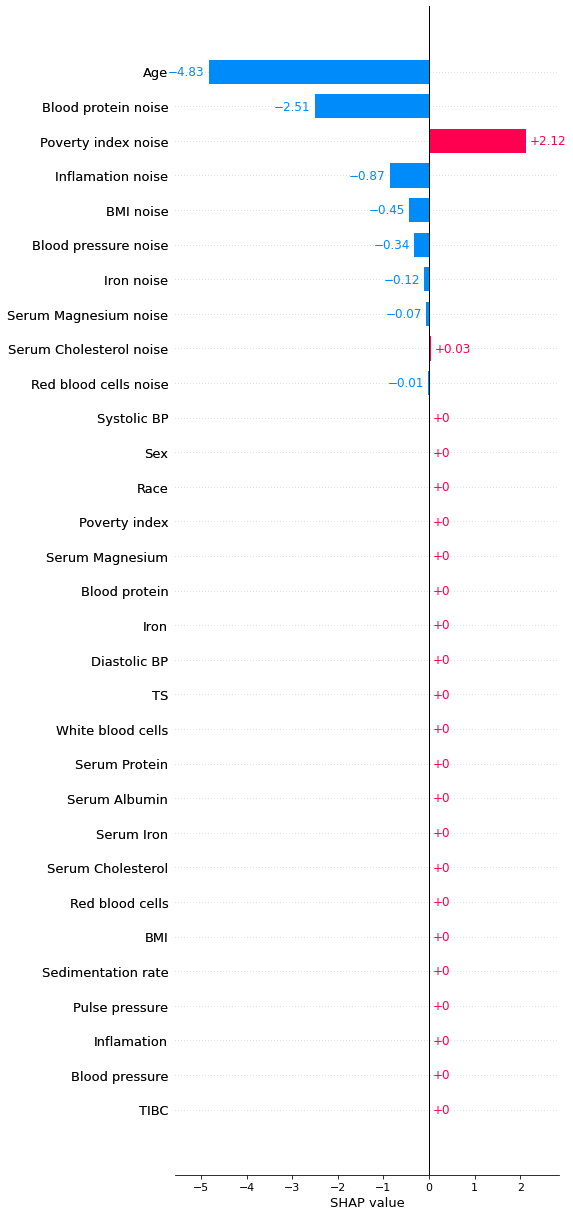

In [28]:
# asv
print('ASV')
def prepare_bar_asv(target_node, edge_credit, sample_ind, graph):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    
    for node in graph: # add internal nodes
        if node.is_target_node or len(node.args) == 0: continue
        b.values.append(0)
        b.input_names.append(node.name)
        
    b.data = None #np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf_flow_nutrition.graph if i.is_target_node][0]
edge_credit = cf_flow_nutrition.get_asv_edge_credit(sample_ind)

b = prepare_bar_asv(target_node, edge_credit, sample_ind, cf_flow_nutrition.graph)
shap.plots.bar(b, max_display=None, show=False)
plt.tight_layout()
plt.show()

In [55]:
n_explain = 100

def get_indirect_effect_flow(cf):
    d = defaultdict(int)
    ec = cf.edge_credit
    for node1, v_dict in ec.items():
        for node2, v in v_dict.items():
            d[node1.name] += v[1:n_explain]

    return d

def get_effect_asv(cf):
    d = defaultdict(int)
    ec = cf.get_asv_edge_credit(aggregate=False)

    for node1, v_dict in ec.items():
        for node2, v in v_dict.items():
            if node2.is_target_node:
                d[node1.name] = v[1:n_explain]

    return d

def get_error(gt, theta, allowed_nodes=None, gt_nodes=None):
    
    if allowed_nodes is not None and gt_nodes is None:
        gt_nodes = allowed_nodes
        
    diff = []
    for k in gt:
        k_gt, k = k, k
        if allowed_nodes is not None:
            l = [node.name for node in allowed_nodes]
            if k in l: # allow for gt use feature node and asv use noise node
                i = l.index(k)
                k_gt = gt_nodes[i].name
            else:
                continue
        diff = np.hstack([diff, gt[k_gt] - theta[k]])
    return diff

def get_effect_ind(cf):
    d = defaultdict(int)
    d.update({k:v[1:n_explain] for k, v in zip(cf.input_names, cf.values.T)})
    return d

def get_effect_manifold(cf):
    d = defaultdict(int)
    d.update({k:v[1:n_explain] for k, v in zip(cf.input_names, cf.values.T)})
    return d

def get_direct_effect_flow(cf):
    d = defaultdict(int)
    ec = cf.edge_credit
    for node1, v_dict in ec.items():
        for node2, v in v_dict.items():
            if node2.is_target_node:
                d[node1.name] = v[1:n_explain]

    return d

def get_direct_effect_ground_truth(graph, X):
    gt = {}
    for n in graph:
        if n.is_target_node: continue

        intervention_on = n.name
        
        d = {}
        for node in graph:
            if not node.is_target_node:
                try:
                    d[node.name] = node.baseline[1:n_explain]
                except:
                    # this is a grouped noise node, just ignore it as it is not a feature
                    d[node.name] = {k: v[1:n_explain] for k, v in node.baseline.items()}
        
        before = eval_graph(graph, d)
        
        try:
            d.update({intervention_on: n.target[1:n_explain]}) # foreground
        except:
            d.update({intervention_on: {k: n.target[k][1:n_explain] for k in n.target}}) # foreground
            
        after = eval_graph(graph, d)

        gt[intervention_on] = after - before
    return gt

def get_direct_gt_bg(bg, graph, X):
    cf = GraphExplainer(graph, X, nruns=1, bg=bg[i:i+1]).shap_values(X[:n_explain], skip_prepare=skip_prepare)

gt = get_direct_effect_ground_truth(cf_flow_nutrition.graph, X)
theta_ind = get_effect_ind(cf_ind_nutrition)
theta_manifold = get_effect_manifold(cf_on_manifold_nutrition)
theta_asv = get_effect_asv(cf_flow_nutrition)
theta_flow = get_direct_effect_flow(cf_flow_nutrition)

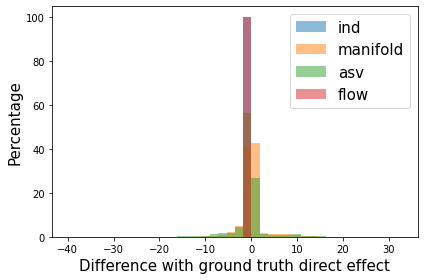

In [38]:
target_node = [node for node in cf_flow_nutrition.graph if node.is_target_node][0]
feature_nodes = target_node.args
feature_noise_nodes = []
for n in feature_nodes:
    corresponding_noise = [node for node in cf_flow_nutrition.graph if node.name == n.name + ' noise']
    if len(corresponding_noise) == 0:
        feature_noise_nodes.append(n)
    else:
        feature_noise_nodes.append(corresponding_noise[0])

errors = {
    'ind': get_error(gt, theta_ind, feature_nodes), # does not compare noise node
    'manifold': get_error(gt, theta_manifold, feature_nodes), # does not compare noise node
    'asv': get_error(gt, theta_asv, feature_noise_nodes), # replace some feature nodes with noise node
    'flow': get_error(gt, theta_flow, feature_nodes) # direct effect focus on feature nodes
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] # get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.5, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth direct effect', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.savefig('figures/nutrition_direct_error.png')
plt.show()

In [50]:
# for k, v in errors.items():
#     l, m, h = np.percentile(np.abs(v), [5, 50, 95])
#     print(f"{k:>10s}: {np.abs(v).mean().round(1)} ({l.round(1)}, {h.round(1)})")
for k, v in errors.items():
    print(f"{k:>10s}: {np.abs(v).mean().round(1)} ($\pm$ {np.abs(v).std().round(1)})")

       ind: 0.0 ($\pm$ 0.0)
  manifold: 1.3 ($\pm$ 2.5)
       asv: 1.5 ($\pm$ 3.3)
      flow: 0.0 ($\pm$ 0.0)


In [56]:
def get_indirect_effect_ground_truth(graph, X):
    gt = {}
    for n in graph:
        if n.is_target_node: continue

        intervention_on = n.name
        sources = get_source_nodes(graph)

        d = {}
        for node in sources:
            if not node.is_target_node:
                try:
                    d[node.name] = node.baseline[1:n_explain]
                except:
                    # this is a grouped noise node, just ignore it as it is not a feature
                    d[node.name] = {k: v[1:n_explain] for k, v in node.baseline.items()}
        
        before = eval_graph(graph, d)

        try:
            d.update({intervention_on: n.target[1:n_explain]}) # foreground
        except:
            d.update({intervention_on: {k: n.target[k][1:n_explain] for k in n.target}}) # foreground

        after = eval_graph(graph, d)

        gt[intervention_on] = after - before
    return gt

gt_indirect = get_indirect_effect_ground_truth(cf_flow_nutrition.graph, X)
theta_flow_indirect = get_indirect_effect_flow(cf_flow_nutrition)

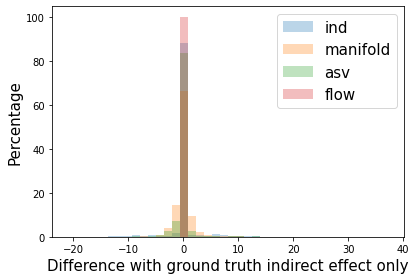

In [57]:
errors = {
    'ind': get_error(gt_indirect, theta_ind, feature_nodes),
    'manifold': get_error(gt_indirect, theta_manifold, feature_nodes),
    'asv': get_error(gt_indirect, theta_asv, feature_noise_nodes, feature_nodes), #need to compare on feature node
    'flow': get_error(gt_indirect, theta_flow_indirect, feature_nodes)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] #get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.3, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth indirect effect only', fontsize=15)
# plt.ylim(0, 300)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.savefig('figures/nutrition_indirect_error.png')
plt.show()

In [53]:
for k, v in errors.items():
    print(f"{k:>10s}: {np.abs(v).mean().round(1)} ($\pm$ {np.abs(v).std().round(1)})")

       ind: 0.8 ($\pm$ 2.7)
  manifold: 0.9 ($\pm$ 1.6)
       asv: 0.6 ($\pm$ 1.9)
      flow: 0.0 ($\pm$ 0.0)


2.711103266539466

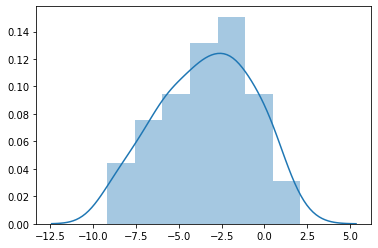

In [37]:
o = f(np.array(X)[:n_explain])
o = o[1:] - o[0]
sns.distplot(o)
np.std(o)